# Intro to STIX Analysis in Python
*written by Hannah Collier for the DynaSun workshop, Sep 2024*


## **If you are using Google Colab, uncomment and run the following:**

In [73]:
# %pip install -r https://raw.githubusercontent.com/hannahc243/DynaSun_tutorial/main/requirements.txt

  Using cached networkx-3.3-py3-none-any.whl.metadata (5.1 kB)
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 24.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 24.8 MB/s eta 0:00:00a 0:00:01
Using cached lazy_loader-0.4-py3-none-any.whl (12 kB)
Using cached networkx-3.3-py3-none-any.whl (1.7 MB)


## Import the required packages

In [1]:
from sunpy.net import Fido, attrs as a
from sunpy.timeseries import TimeSeries
from sunpy.time import parse_time
from sunpy.map import Map
from stixpy.net.client import STIXClient  # Registers the STIXClient with Fido
from stixpy.product import Product
from stixpy import timeseries # Registers the STIX timeseries with TimeSeries
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.time import Time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter

In [2]:
# %matplotlib widget

## Reading in the STIX flarelist

Here we show how to read in the stix science flarelist for further analysis. Further details about how this list was generated and what it includes can be found [here](https://github.com/hayesla/stix_flarelist_science). 

In [3]:
stx_flarelist = pd.read_csv("https://raw.githubusercontent.com/hayesla/stix_flarelist_science/main/STIX_flarelist_w_locations_20210318_20240801_version1_pythom.csv")

In [4]:
stx_flarelist.head()

,start_UTC,end_UTC,peak_UTC,4-10 keV,10-15 keV,15-25 keV,25-50 keV,50-84 keV,att_in,bkg 4-10 keV,...,hgs_lat,hgc_lon,hgc_lat,solo_position_lat,solo_position_lon,solo_position_AU_distance,GOES_class_time_of_flare,GOES_flux_time_of_flare,flare_id,sidelobes_ratio
0,2021-03-18T14:51:39.337,2021-03-18T14:58:55.337,2021-03-18T14:53:07.337,5375,335,99,927,543,False,271.0,...,20.339668,244.371990,20.339668,1.601911,-110.598275,0.666330,A,3.488101e-08,2103181453,0.766586
1,2021-03-19T14:01:39.177,2021-03-19T14:21:03.183,2021-03-19T14:05:31.178,1215,99,91,927,543,False,271.0,...,20.822767,222.118021,20.822767,1.565540,-109.851528,0.672826,A,3.917223e-08,2103191405,0.754688
2,2021-03-19T18:34:35.205,2021-03-19T18:53:51.109,2021-03-19T18:42:43.108,2687,183,99,927,543,False,271.0,...,20.755609,222.854340,20.755609,1.558217,-109.706731,0.674117,A,4.179104e-08,2103191842,0.760059
3,2021-03-20T09:04:39.093,2021-03-20T09:12:19.094,2021-03-20T09:06:39.093,1087,123,91,927,543,False,271.0,...,20.222089,224.407464,20.222089,1.535231,-109.263524,0.678135,A,4.073035e-08,2103200906,0.770594
4,2021-03-20T12:03:31.111,2021-03-20T12:29:11.114,2021-03-20T12:14:59.112,1727,151,91,927,543,False,271.0,...,20.546974,221.863290,20.546974,1.530189,-109.168512,0.679010,A,5.101582e-08,2103201214,0.766514


In [5]:
stx_flarelist.columns

Index(['start_UTC', 'end_UTC', 'peak_UTC', '4-10 keV', '10-15 keV',
       '15-25 keV', '25-50 keV', '50-84 keV', 'att_in', 'bkg 4-10 keV',
       'bkg 10-15 keV', 'bkg 15-25 keV', 'bkg 25-50 keV', 'bkg 50-84 keV',
       'bkg_baseline_4-10 keV', 'hpc_x_solo', 'hpc_y_solo', 'hpc_x_earth',
       'hpc_y_earth', 'visible_from_earth', 'hgs_lon', 'hgs_lat', 'hgc_lon',
       'hgc_lat', 'solo_position_lat', 'solo_position_lon',
       'solo_position_AU_distance', 'GOES_class_time_of_flare',
       'GOES_flux_time_of_flare', 'flare_id', 'sidelobes_ratio'],
      dtype='object')

## Downloading Data with Fido

Data can be downloaded through sunpy's Fido using the STIX client. Here we show how to search for and download different types of STIX data using Fido. 

In order to reduce telemetry, STIX data is compressed onboard the Solar Orbiter satellite. One way this is done is by creating various data products that each serve different purposes. These include e.g. quicklook products, spectrogram files & compressed pixel data. 

In [29]:
query = Fido.search(a.Instrument.stix, a.Time('2024-03-10 11:45', '2024-03-10 12:30'))

In [30]:
query

Start Time,End Time,Instrument,Level,DataType,DataProduct,Ver,Request ID
object,object,str4,str2,str3,str20,str4,str21
2024-03-10 00:00:00.000,2024-03-10 23:59:59.999,STIX,L1,QL,ql-lightcurve,V02,-
2024-03-10 00:00:00.000,2024-03-10 23:59:59.999,STIX,L1,QL,ql-background,V02,-
2024-03-10 00:00:00.000,2024-03-10 23:59:59.999,STIX,L1,QL,ql-variance,V02,-
2024-03-10 00:00:00.000,2024-03-10 23:59:59.999,STIX,L1,QL,ql-spectra,V02,-
2024-03-10 00:00:00.000,2024-03-10 23:59:59.999,STIX,L1,QL,ql-flareflag,V02,-
2024-03-10 00:00:00.000,2024-03-10 23:59:59.999,STIX,L1,QL,ql-tmstatusflarelist,V02,-
2024-03-10 11:56:26.000,2024-03-10 12:45:18.000,STIX,L1,SCI,sci-xray-cpd,V02,2403102193
2024-03-10 11:59:06.000,2024-03-10 12:15:40.000,STIX,L1,SCI,sci-xray-cpd,V02,2403109216
2024-03-10 07:35:05.000,2024-03-10 13:40:08.000,STIX,L1,SCI,sci-xray-spec,V02,2403103995


In [41]:
query_ql = Fido.search(a.Instrument.stix, a.Time('2024-03-10 11:45', '2024-03-10 12:30'), a.stix.DataType.sci)

In [42]:
query_ql

Start Time,End Time,Instrument,Level,DataType,DataProduct,Ver,Request ID
str23,str23,str4,str2,str3,str13,str3,int64
2024-03-10 11:56:26.000,2024-03-10 12:45:18.000,STIX,L1,SCI,sci-xray-cpd,V02,2403102193
2024-03-10 11:59:06.000,2024-03-10 12:15:40.000,STIX,L1,SCI,sci-xray-cpd,V02,2403109216
2024-03-10 07:35:05.000,2024-03-10 13:40:08.000,STIX,L1,SCI,sci-xray-spec,V02,2403103995


In [31]:
res_ql = Fido.fetch(query[0][0])
res_cpd = Fido.fetch(query[0][7])
res_spec = Fido.fetch(query[0][-4])

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

Exception ignored in: <function BaseEventLoop.__del__ at 0x10ababec0>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/dynasun/lib/python3.12/asyncio/base_events.py", line 728, in __del__
    self.close()
  File "/opt/anaconda3/envs/dynasun/lib/python3.12/asyncio/unix_events.py", line 71, in close
    self.remove_signal_handler(sig)
  File "/opt/anaconda3/envs/dynasun/lib/python3.12/asyncio/unix_events.py", line 160, in remove_signal_handler
    signal.signal(sig, handler)
  File "/opt/anaconda3/envs/dynasun/lib/python3.12/signal.py", line 58, in signal
    handler = _signal.signal(_enum_to_int(signalnum), _enum_to_int(handler))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: signal only works in main thread of the main interpreter


## Quicklook Data

Quicklook data can be used to get an overview of the available STIX data during a particular time period and to search for events of interest. It is highly compressed data at 4s time resolution. In the steps which follow we read in and plot the quicklook timeseries data.

In [5]:
ql_lc = TimeSeries(res_ql)

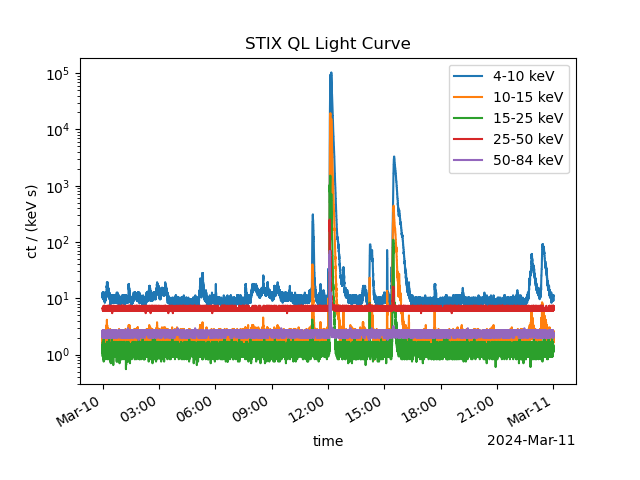

In [7]:
ql_lc.peek()


## Spectrogram Data

In spectrogram data files the pixels have been summed such that no spatial information is available. Therefore spectrogram files only contain temporal and spectral information. The are often long duration files at relatively low time resolution. 

In [8]:
spec = Product(res_spec)

(np.float64(19792.493055555555), np.float64(19792.534722222223))

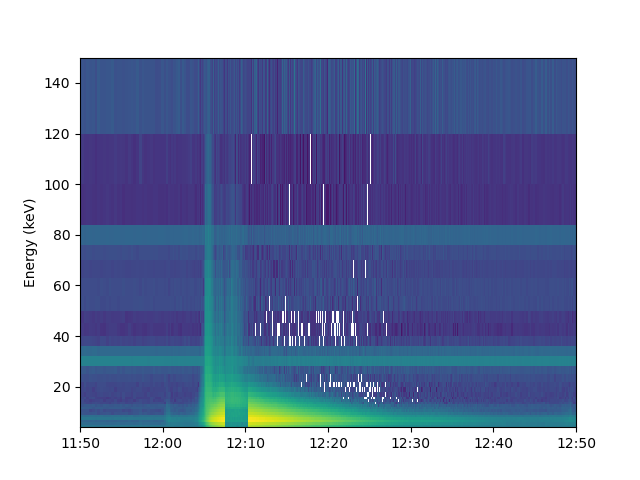

In [9]:
fig,ax=plt.subplots()
spec.plot_spectrogram(axes=ax)
ax.set_ylabel('Energy (keV)')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlim([parse_time('2024-03-10 11:50').to_datetime(),parse_time('2024-03-10 12:50').to_datetime()] )

## Compressed Pixel Data

Compressed pixel data files are typically the files with the largest volume as they contain temporal, spectral and spatial information at high time resolution. They are used in imaging and any analysis requiring high time cadence observations. 

In [32]:
cpd = Product(res_cpd)

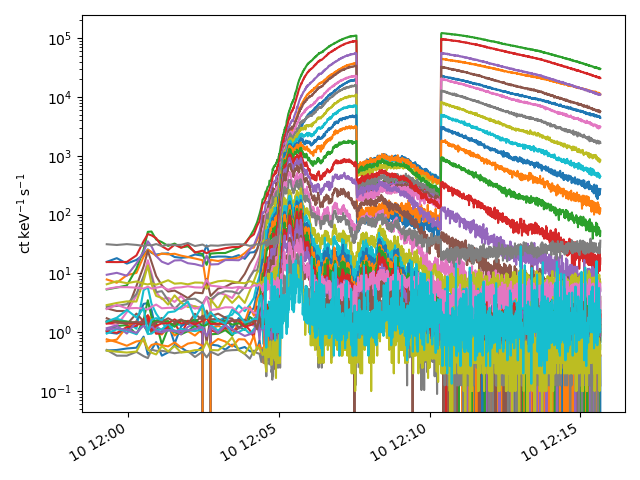

In [11]:
cpd.plot_timeseries()

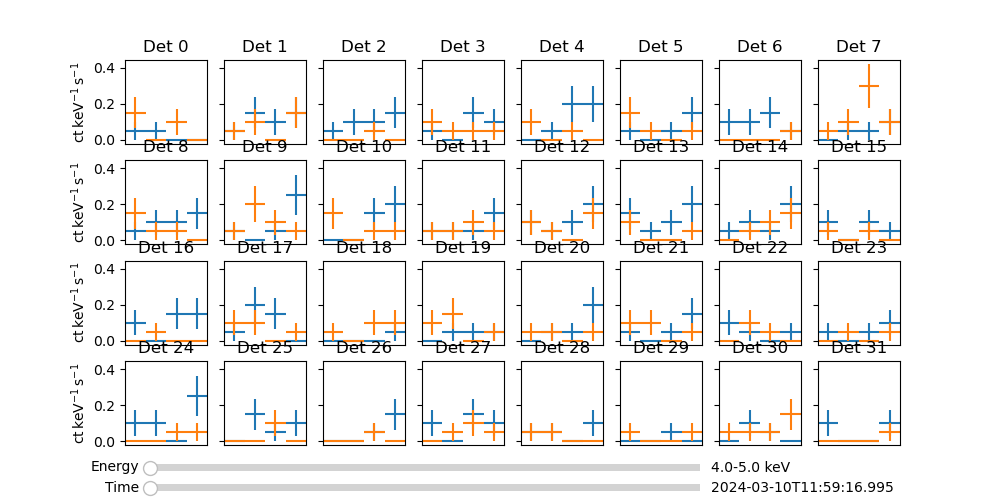

In [12]:
cpd.plot_pixels()

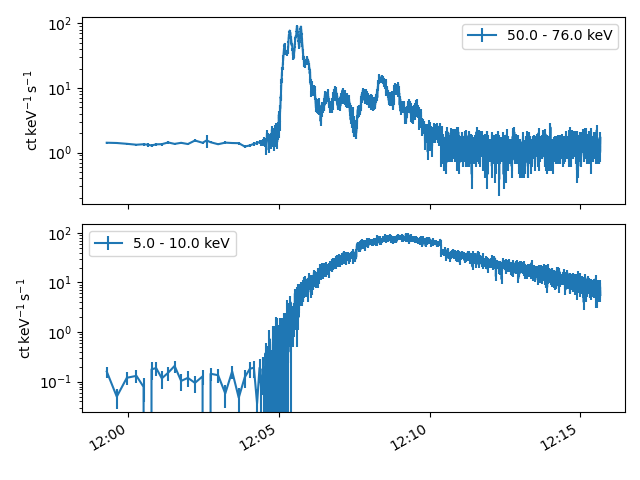

In [14]:
fig,ax=plt.subplots(2,1, sharex=True)
cpd.plot_timeseries(axes=ax[0], energy_indices = [[22,25]], error_bar=True)
ax[0].legend()
cpd.plot_timeseries(axes=ax[1], energy_indices = [[1,5]], detector_indices = [9], pixel_indices = [[2,5]], error_bar=True)
ax[1].legend()
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))


In [15]:
counts, errors, times, deltatimes, energies = cpd.get_data(energy_indices=[[22,25]])

In [16]:
counts.to(u.ct/u.s/u.keV)

<Quantity [[[[0.00769231],
             [0.00576923],
             [0.00769231],
             ...,
             [0.00384615],
             [0.00384615],
             [0.00769231]],

            [[0.00384615],
             [0.00769231],
             [0.00576923],
             ...,
             [0.00192308],
             [0.00576923],
             [0.00576923]],

            [[0.00961538],
             [0.00576923],
             [0.        ],
             ...,
             [0.00384615],
             [0.00384615],
             [0.00192308]],

            ...,

            [[0.00576923],
             [0.00384615],
             [0.00961538],
             ...,
             [0.00576923],
             [0.00384615],
             [0.00576923]],

            [[0.00769231],
             [0.00769231],
             [0.00769231],
             ...,
             [0.00384615],
             [0.00576923],
             [0.00769231]],

            [[0.00769231],
             [0.00576923],
             [0.  

## Quicklook Imaging

The images shown here were created using the automatic imaging pipeline available through the [STIX data center](https://datacenter.stix.i4ds.net/). With this we can get a quick overview of the source of X-ray emission observed by STIX and its relation to other observations e.g. from AIA.

*N.B. Quicklook images from the automatically generated pipeline should not be used in publications.*

**If you are using Google Colab you will need to download the STIX imaging file manually from the STIX data center and put it in your Google Drive working folder** 

In [83]:
stx_clean_maps = Map('stix_L3A_quicklook_20240310T120507-20240310T120536-32.0-84.0keV_2403109216_248_user_clean_hpc.fits')

In [18]:
parse_time(stx_clean_maps[4].meta['date-avg']) + cpd.meta['EAR_TDEL']*u.s

<Time object: scale='utc' format='isot' value=2024-03-10T12:08:58.037>

In [84]:
aia_query = Fido.search(a.Instrument.aia, a.Time('2024-03-10 12:08:58','2024-03-10 12:09:58'), a.Wavelength(1600*u.Angstrom))

In [85]:
aia_query

Start Time,End Time,Source,Instrument,Wavelength,Provider,Physobs,Wavetype,Extent Width,Extent Length,Extent Type,Size
,,,,Angstrom,,,,,,,Mibyte
Time,Time,str3,str3,float64[2],str4,str9,str6,str4,str4,str8,float64
2024-03-10 12:09:02.000,2024-03-10 12:09:03.000,SDO,AIA,1600.0 .. 1600.0,JSOC,intensity,NARROW,4096,4096,FULLDISK,64.64844
2024-03-10 12:09:26.000,2024-03-10 12:09:27.000,SDO,AIA,1600.0 .. 1600.0,JSOC,intensity,NARROW,4096,4096,FULLDISK,64.64844
2024-03-10 12:09:50.000,2024-03-10 12:09:51.000,SDO,AIA,1600.0 .. 1600.0,JSOC,intensity,NARROW,4096,4096,FULLDISK,64.64844


In [87]:
aia_res = Fido.fetch(aia_query[0][0])

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

In [88]:
aia_map = Map(aia_res)

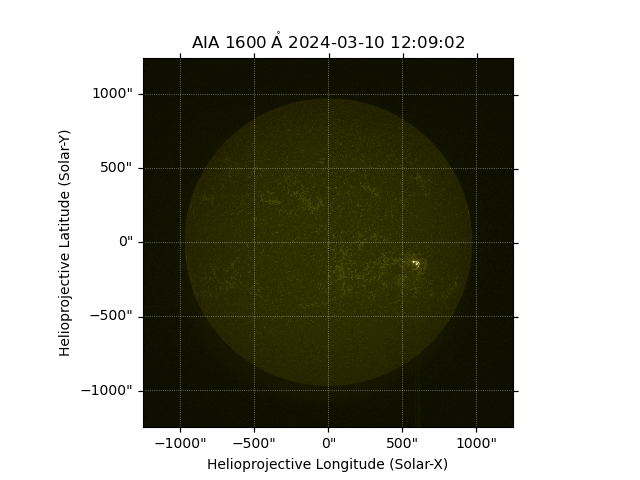

In [89]:
fig = plt.figure()
ax = fig.add_subplot(projection = aia_map.wcs)
aia_map.plot(axes=ax)

In [90]:
bl = SkyCoord(400*u.arcsec, -300*u.arcsec, frame = aia_map.coordinate_frame)
tr = SkyCoord(800*u.arcsec, 0*u.arcsec, frame = aia_map.coordinate_frame)

In [91]:
aia_submap = aia_map.submap(bottom_left=bl, top_right=tr)

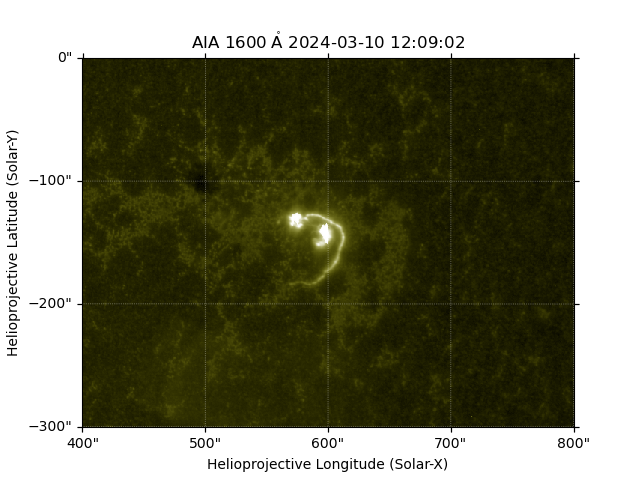

In [92]:
fig = plt.figure()
ax = fig.add_subplot(projection = aia_submap.wcs)
aia_submap.plot()

In [27]:
stx_clean_maps[4].meta['rsun_ref'] = aia_submap.meta['rsun_ref']

In [28]:
reprojected_stx_map = stx_clean_maps[4].reproject_to(aia_submap.wcs)

2024-09-04 00:13:38 - reproject.common - INFO: Calling _reproject_full in non-dask mode


Text(0.5, 1.0, '2024-03-10T12:05:22.095')

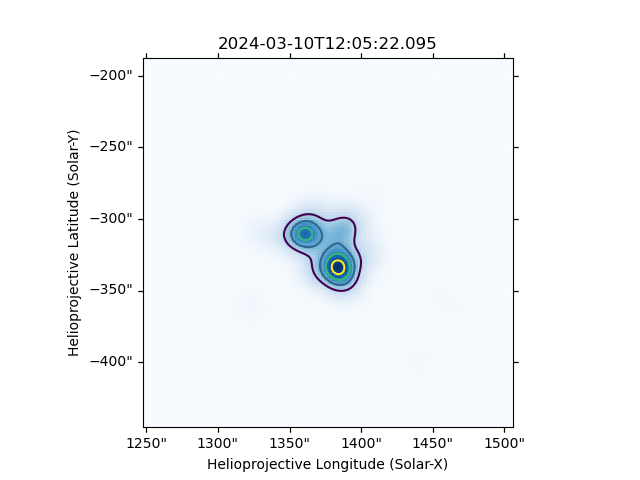

In [29]:
fig = plt.figure()
ax = fig.add_subplot(projection = stx_clean_maps[4].wcs)
stx_clean_maps[4].plot(cmap='Blues')
stx_clean_maps[4].draw_contours(np.arange(30,100,20)*u.percent)
ax.set_title(f'{stx_clean_maps[4].meta['date-avg']}')

Text(0.5, 1.0, '2024-03-10T12:09:03.580')

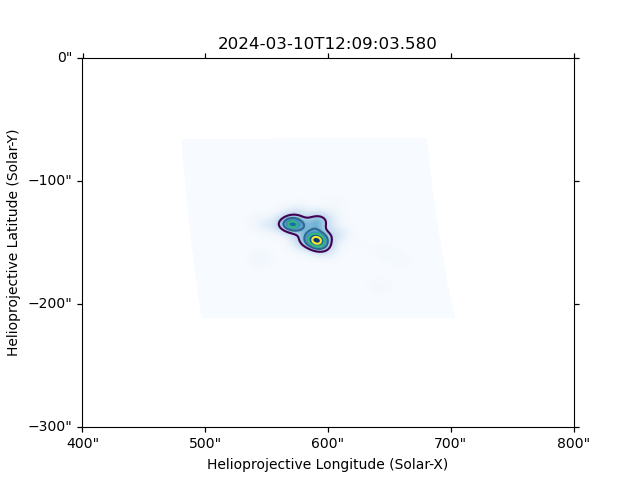

In [30]:
fig = plt.figure()
ax = fig.add_subplot(projection = reprojected_stx_map.wcs)
reprojected_stx_map.plot(cmap='Blues')
reprojected_stx_map.draw_contours(np.arange(30,100,20)*u.percent)
ax.set_title(f'{reprojected_stx_map.meta['date-avg']}')

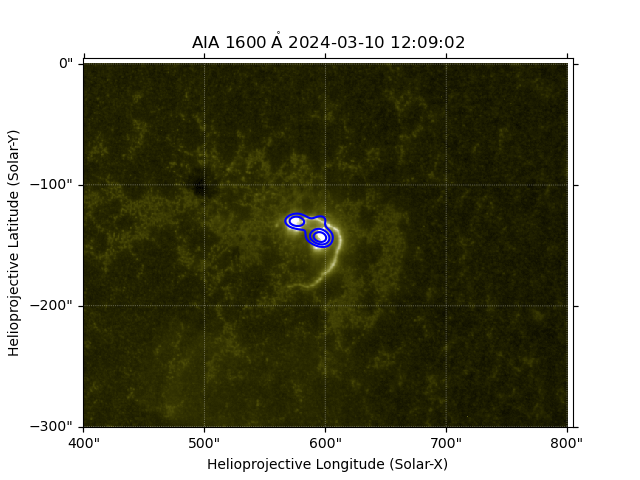

In [31]:
fig = plt.figure()
ax = fig.add_subplot(projection = aia_submap.wcs)
aia_submap.plot()
reprojected_stx_map.shift_reference_coord(5*u.arcsec, 5*u.arcsec).draw_contours(np.arange(40,100,20)*u.percent, colors='blue')

## Now let's look at a fun example of a flare displaying thermal X-ray QPPs!

*from French et al. 2024 (under review).*

In [5]:
query_th_qpp = Fido.search(a.Instrument.stix, a.Time('2022-08-29 16:00', '2022-08-29 17:30'), a.stix.DataType.sci)

In [6]:
res_th_qpp = Fido.fetch(query_th_qpp[0][2])

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

In [7]:
cpd_th_qpp = Product(res_th_qpp)

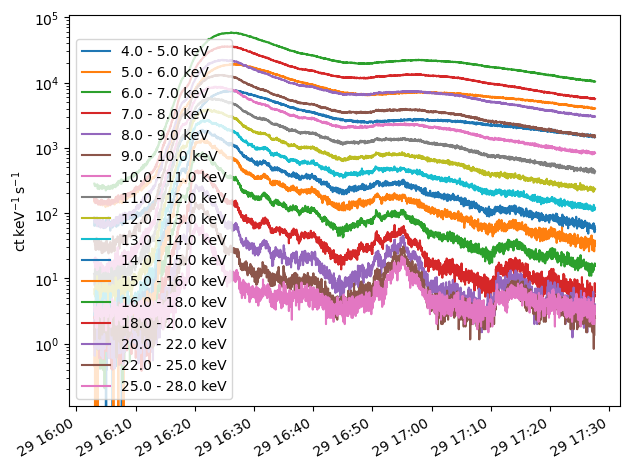

In [8]:
cpd_th_qpp.plot_timeseries()
plt.legend()

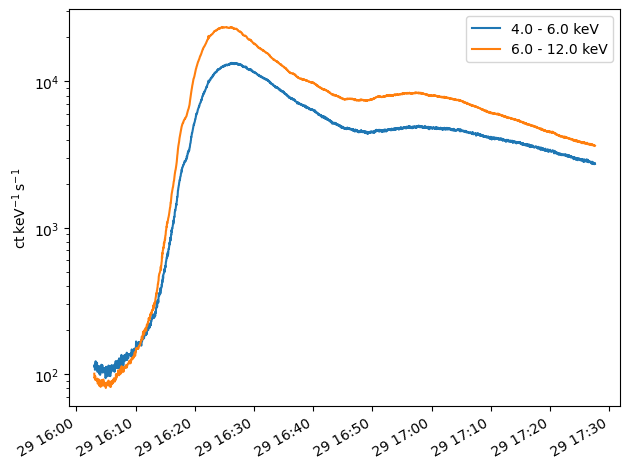

In [9]:
cpd_th_qpp.plot_timeseries(energy_indices = [[0,1],[2,7]])
plt.legend()

In [10]:
counts_th_qpps, errors_th_qpps, times_th_qpps, deltatimes_th_qpps, energies_th_qpps = cpd_th_qpp.get_data(detector_indices = [[0,31]], pixel_indices = [[0,12]], energy_indices = [[0,1],[2,7]])

In [11]:
counts_4_6 = counts_th_qpps.to(u.ct/u.s/u.keV)[:,:,:,0].reshape(-1).value
counts_6_12 = counts_th_qpps.to(u.ct/u.s/u.keV)[:,:,:,1].reshape(-1).value

Text(42.597222222222214, 0.5, 'Time bin duration (s)')

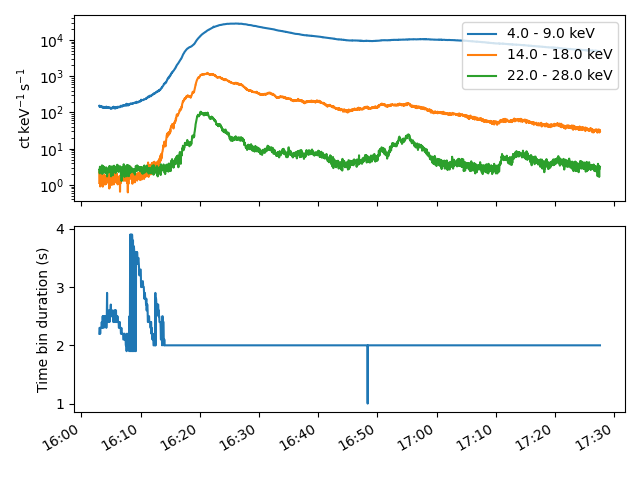

In [62]:
fig,ax=plt.subplots(2,1, sharex=True)
cpd_th_qpp.plot_timeseries(energy_indices = [[0,1], [10,12],[15,16]], axes=ax[0])
ax[0].legend(loc='upper right')
ax[1].plot(times_th_qpps.datetime, cpd_th_qpp.duration.to(u.s).value)
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax[1].set_ylabel('Time bin duration (s)')


In [17]:
smooth_deriv_4_6 = savgol_filter(counts_4_6, window_length=20, polyorder=3, deriv=1)
smooth_deriv_6_12 = savgol_filter(counts_6_12, window_length=20, polyorder=3, deriv=1)

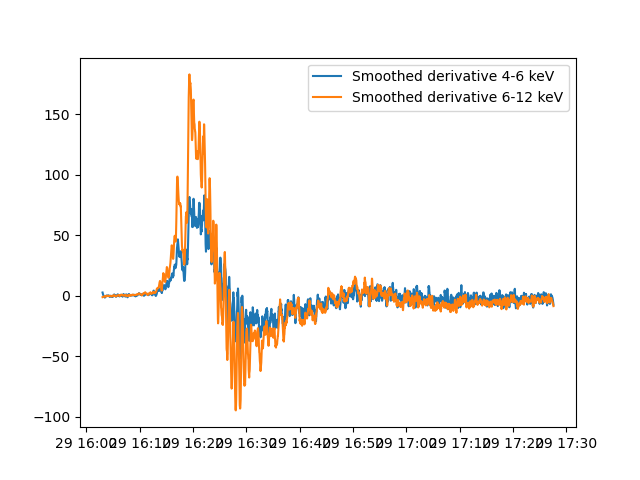

In [18]:
fig,ax=plt.subplots()
ax.plot(times_th_qpps.datetime, smooth_deriv_4_6, label='Smoothed derivative 4-6 keV')
ax.plot(times_th_qpps.datetime, smooth_deriv_6_12, label='Smoothed derivative 6-12 keV')
ax.legend()

### Let's compare with GOES data...

In [19]:
query_th_qpp_goes = Fido.search(a.Instrument.goes,  a.Time('2022-08-29 16:00', '2022-08-29 17:30'))

In [20]:
goes_res = Fido.fetch(query_th_qpp_goes[0][0] )

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

In [21]:
goes_ts = TimeSeries(goes_res)

<Axes: ylabel='Watts m$^{-2}$'>

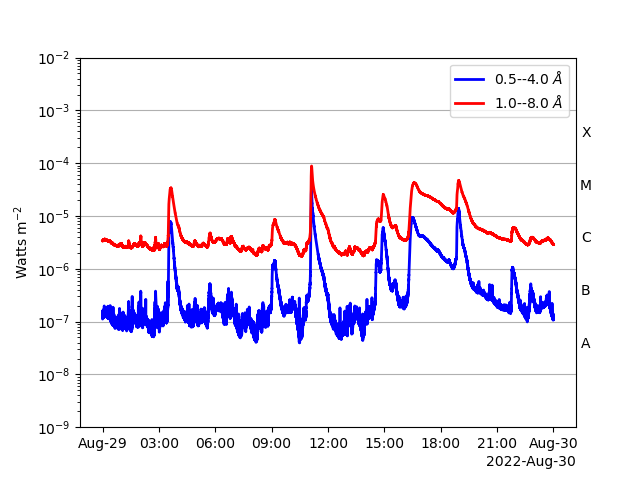

In [22]:
fig,ax=plt.subplots()
goes_ts.plot(axes=ax)

In [23]:
df_goes = goes_ts.to_dataframe()

df_goes_truncated = df_goes.truncate(before = parse_time('2022-08-29 16:10').to_datetime(), after = parse_time('2022-08-29 17:00').to_datetime())

In [25]:
goes_time = df_goes_truncated.index
goes_deriv = np.gradient(df_goes_truncated['xrsa'])
goes_deriv_smoothed = savgol_filter(goes_deriv, window_length = 40, polyorder=3)

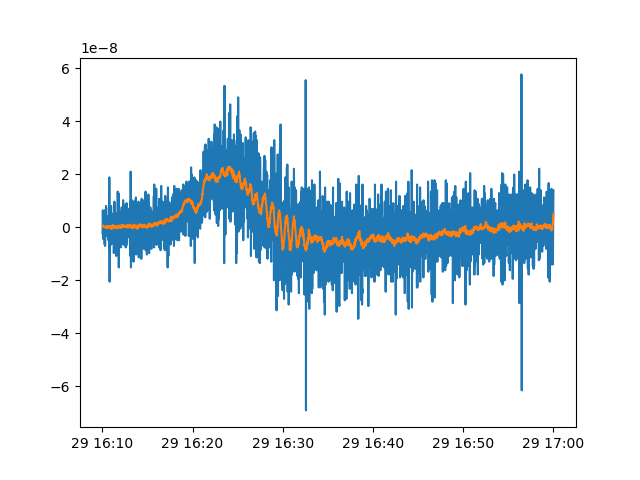

In [26]:
fig,ax=plt.subplots()
ax.plot(goes_time, goes_deriv)
ax.plot(goes_time, goes_deriv_smoothed)

Text(0.5, 141.47286656924004, '2022-08-29')

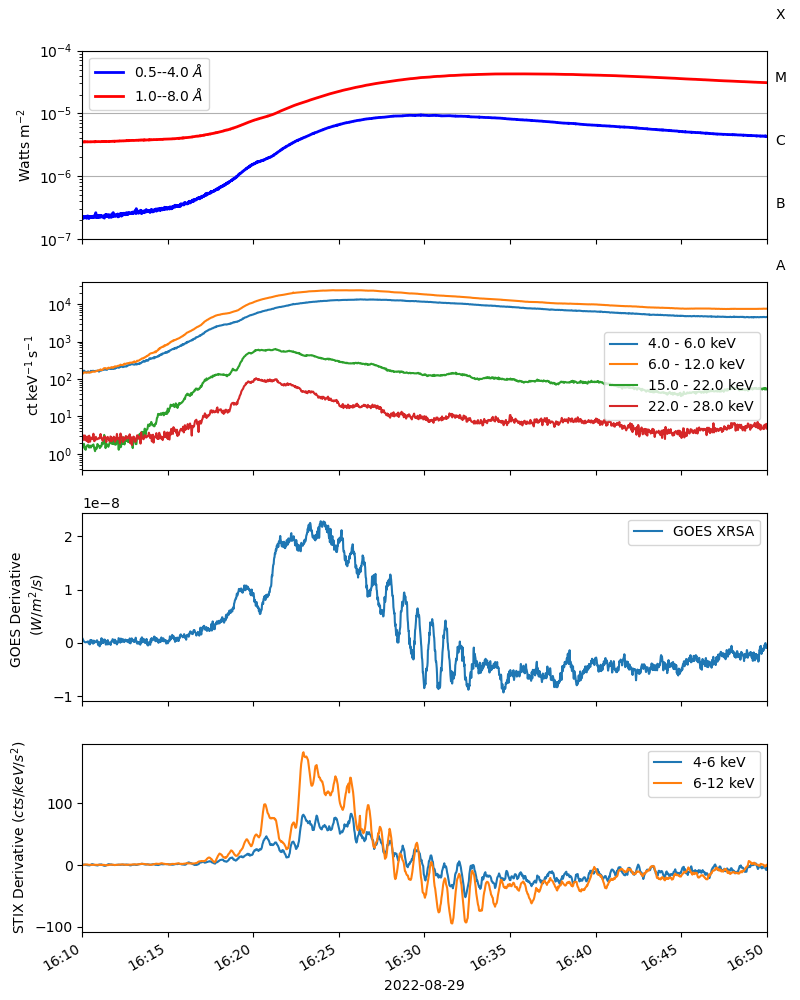

In [33]:
fig,ax=plt.subplots(4,1, sharex=True, figsize=[8,10])
goes_ts.plot(axes=ax[0])
ax[0].set_ylim([10**(-7), 10**(-4)])

cpd_th_qpp.plot_timeseries(axes=ax[1], energy_indices=[[0,1],[2,7], [11,14], [15,16]])
ax[1].legend()

ax[2].plot(goes_time, goes_deriv_smoothed, label='GOES XRSA')
ax[2].set_ylabel('GOES Derivative \n ($W/m^2/s$)')
ax[2].legend()

ax[3].plot((Time(times_th_qpps.datetime) + cpd.meta['EAR_TDEL']*u.s).datetime, smooth_deriv_4_6, label='4-6 keV')
ax[3].plot((Time(times_th_qpps.datetime) + cpd.meta['EAR_TDEL']*u.s).datetime, smooth_deriv_6_12, label='6-12 keV')
ax[3].set_xlim([parse_time('2022-08-29 16:10').datetime, parse_time('2022-08-29 16:50').datetime])
ax[3].set_ylabel('STIX Derivative ($cts/keV/s^2$)')
ax[3].legend()
ax[3].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax[3].set_xlabel('2022-08-29')